In [71]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [72]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import r2_score

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [74]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [75]:
df_country.loc[df_country.Country=='US'].tail()

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
12296,US,2020-03-29,140886,2020-01-22,68,19408.0,4.219508,11.855706,9.873441
12477,US,2020-03-30,161807,2020-01-22,69,20921.0,4.234107,11.994160,9.948509
12658,US,2020-03-31,188172,2020-01-22,70,26365.0,4.248495,12.145112,10.179793
12839,US,2020-04-01,213372,2020-01-22,71,25200.0,4.262680,12.270792,10.134599
13020,US,2020-04-02,243453,2020-01-22,72,30081.0,4.276666,12.402679,10.311649


In [76]:
df_state.loc[df_state.State == 'New York'].tail()

,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
1035,New York,2020-03-28,53363,2020-03-01,28,8728.0,3.332205,10.884873,9.074292
1036,New York,2020-03-29,59568,2020-03-01,29,6205.0,3.367296,10.994874,8.733111
1037,New York,2020-03-30,67174,2020-03-01,30,7606.0,3.401197,11.115042,8.936693
1038,New York,2020-03-31,75832,2020-03-01,31,8658.0,3.433987,11.236276,9.066239
1039,New York,2020-04-01,83889,2020-03-01,32,8057.0,3.465736,11.337250,8.994297


### Regression of actual cases using weighted local regression

In [77]:
x = df_country.loc[df_country.Country=='US'].DaysElapsed.values
y = df_country.loc[df_country.Country=='US'].Confirmed.values

In [78]:
lowess = regress(x, y, how='lowess')

d = 3
x_range, y_hat = predict(x, lowess[1], days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_hat,2))), columns =['DaysElapsed', 'ConfirmedPred']) 
preds

R2 for lowess: 0.99981


,DaysElapsed,ConfirmedPred
0,73,266932.53
1,74,292835.33
2,75,318738.13


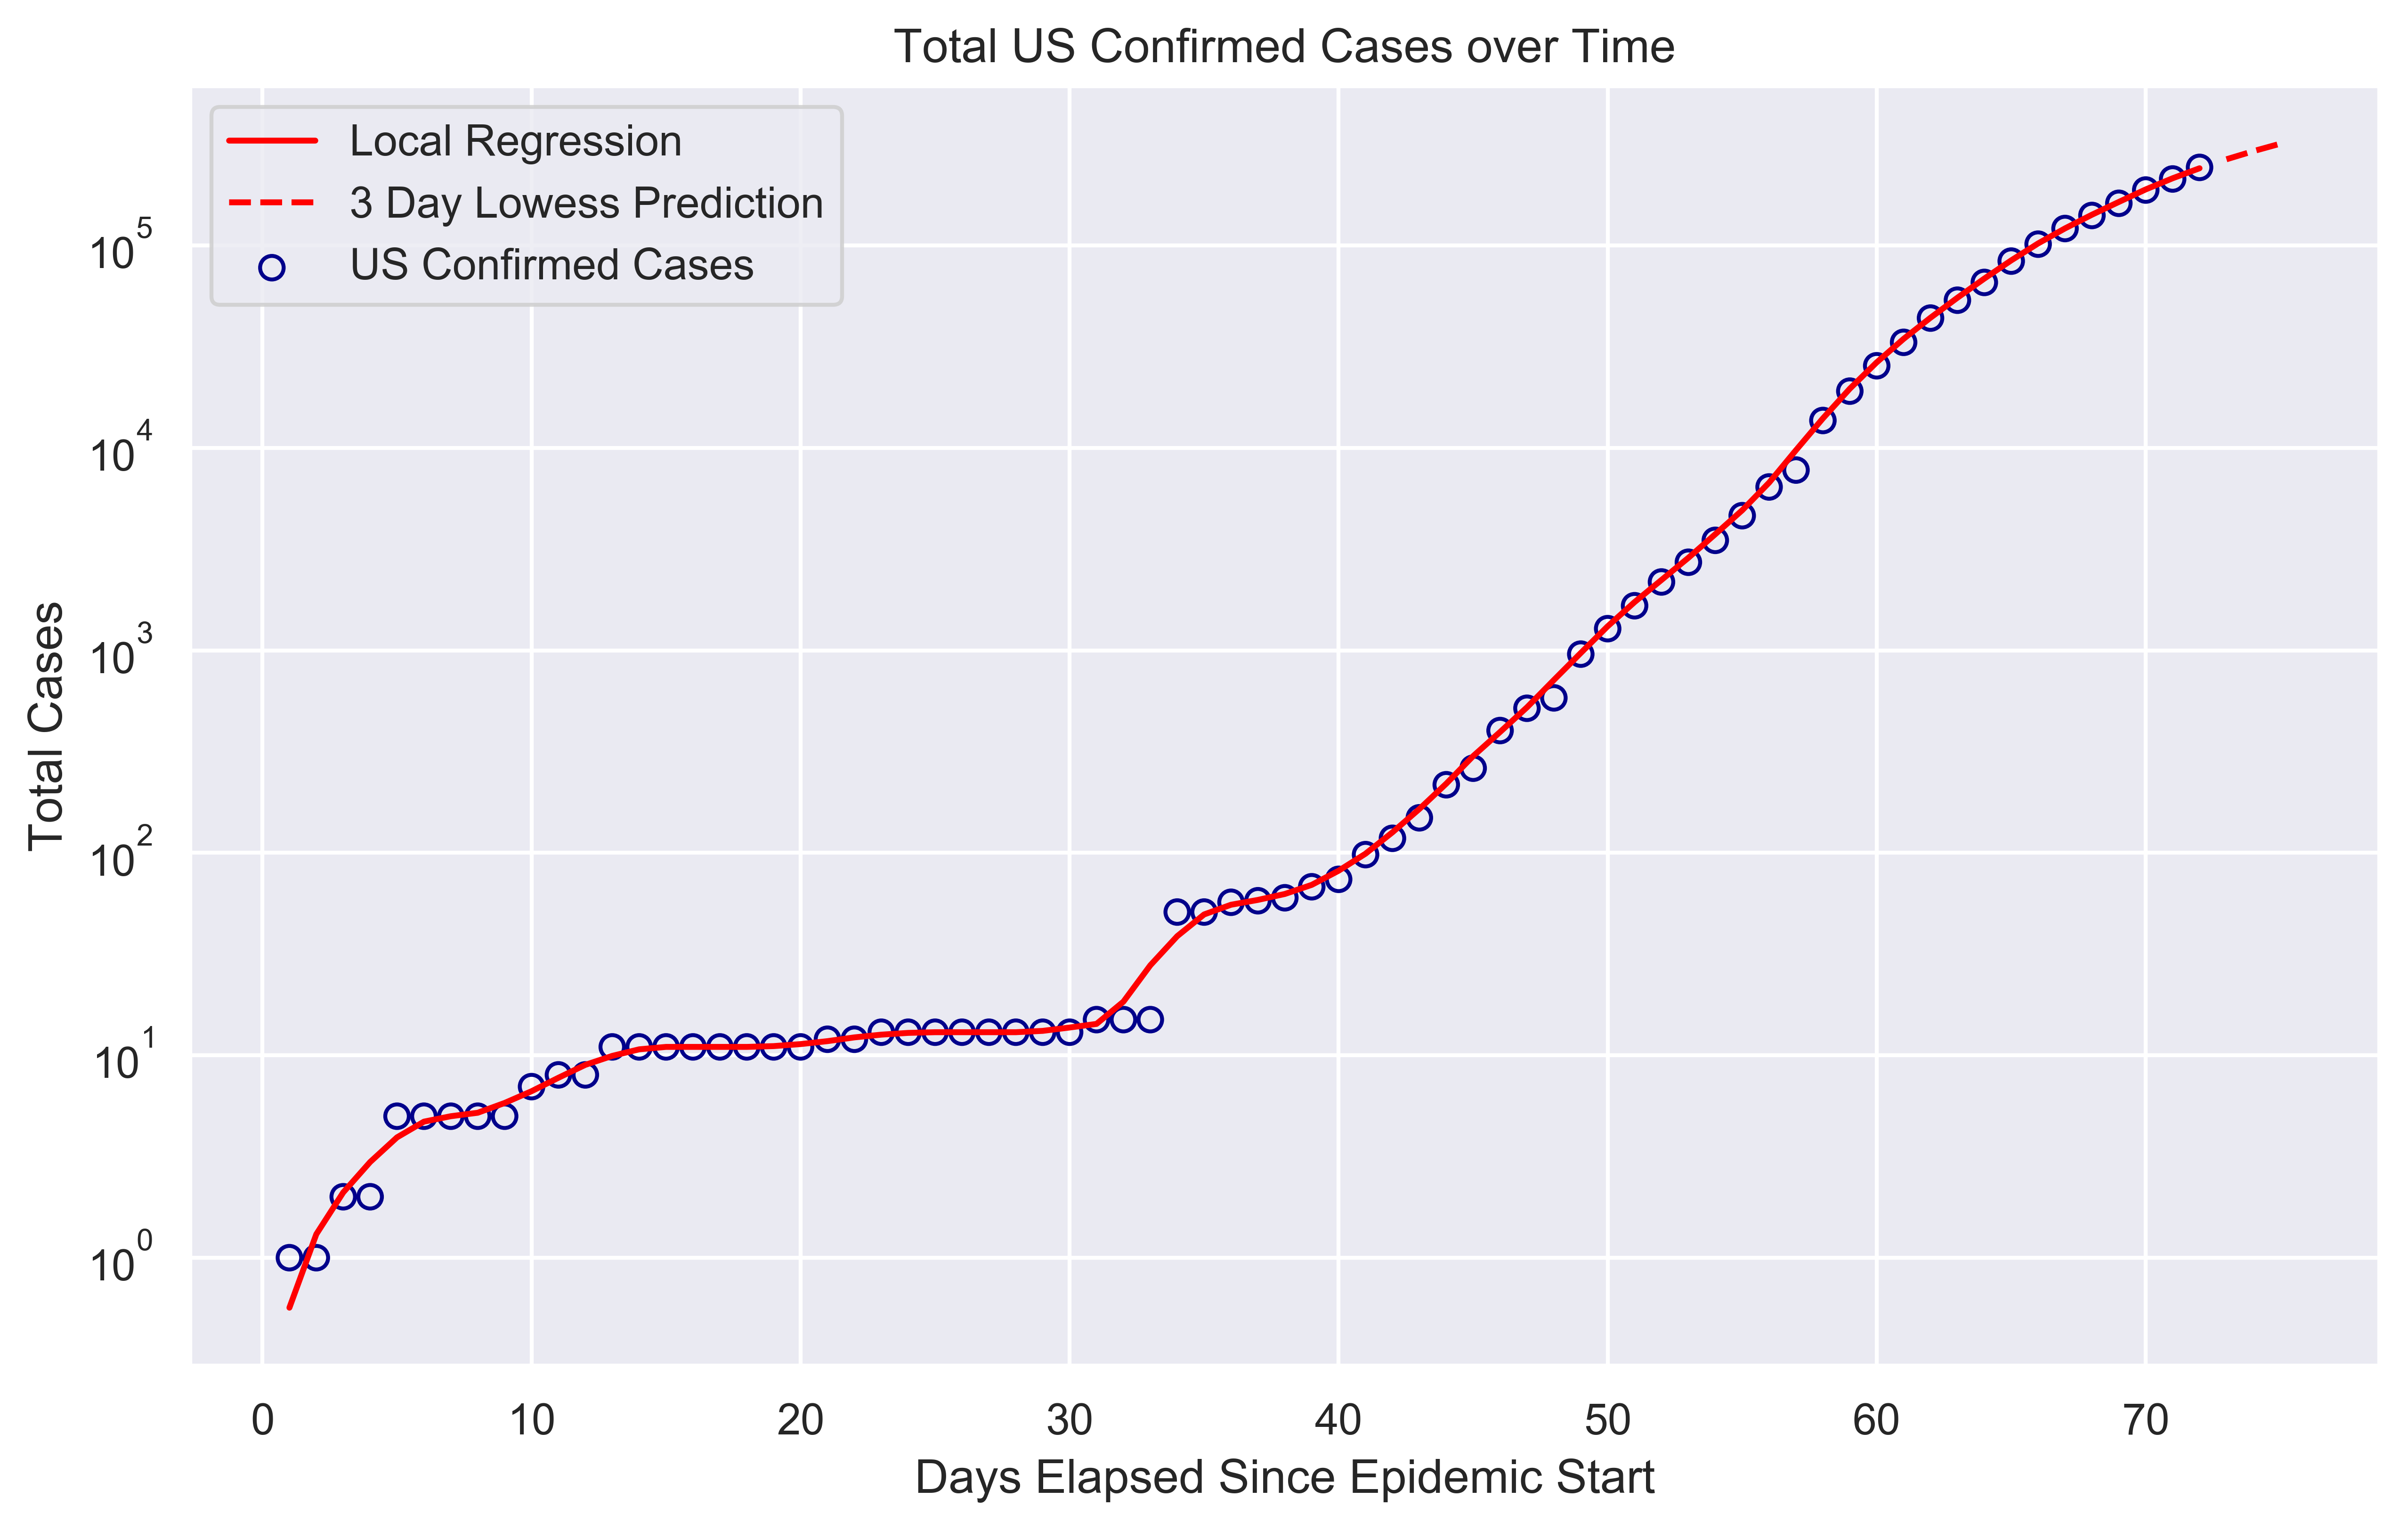

In [79]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors = 'none', edgecolor = 'darkblue', label = 'US Confirmed Cases')
plt.plot(x, lowess[1], color = 'red', label = 'Local Regression')
# plt.plot(x, exp[1], color = 'orange', label = 'exp')

plt.plot(x_range, y_hat, '--', color = 'red', label = '{} Day Lowess Prediction'.format(d))
# plt.plot(x_extended, y_hat_exp, color = 'orange', label = 'exp')

plt.yscale('log')

plt.legend()
plt.ylabel('Total Cases')
plt.xlabel('Days Elapsed Since Epidemic Start')
plt.title('Total US Confirmed Cases over Time')
plt.show()